# DRC Roads - UDM2

In this notebook we compare the results of forest degredation detection using PSOrthotiles and UDM2 vs UDM.

In [7]:
from collections import OrderedDict
import datetime
import json
import os
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from planet import api
from planet.api import downloader, filters
import rasterio
from shapely import geometry as sgeom
from shapely.ops import cascaded_union

## Define AOI

The AOI is a region in the Democratic Republic of Congo that experiences road development between September and November 2017. It is a rectangle that overlaps orthotile grid cell boundaries. Usually, we would redefine the AOI to be within an Orthotile, but we would lose a lot of context if we limited this AOI to only one Orthotile grid cell.

In [2]:
aoi = {"geometry": {
    "type":"Polygon",
    "coordinates":
        [[
            [25.42429478260258,1.0255377823058893],
            [25.592960813580472,1.0255377823058893],
            [25.592960813580472,1.1196578801254304],
            [25.42429478260258,1.1196578801254304],
            [25.42429478260258,1.0255377823058893]
        ]]}}

item_type = 'PSOrthoTile'

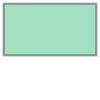

In [3]:
aoi_shape = sgeom.shape(aoi['geometry'])
aoi_shape

In [4]:
def create_save_dir(root_dir='data'):
    save_dir = root_dir

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    return save_dir

def save_geojson_file(aoi_geojson, save_dir):
    filename = os.path.join(save_dir, 'aoi.geojson')
    with open(filename, "w") as f:
        f.write(json.dumps(aoi_geojson))
    return filename

geojson_filename = save_geojson_file(aoi, create_save_dir('pre-data'))
print('wrote AOI to {}'.format(geojson_filename))

wrote AOI to pre-data/aoi.geojson


## Download and Mosaic Multiple Strip Orthotile COGs

This process is much like the process for downloading and mosaicing a single strip orthotile, but we want to trigger the download as soon as all scenes in a strip are activated. So this will require a bit of a change to the `on_complete()` function.

In [8]:
class StripDownloader(object):
    def __init__(self, scenes, geojson_file, client, root_dir='data'):
        self.scenes = scenes #pandas DataFrame describing scenes to download
        self.geojson_file = geojson_file
        self.client = client
        self.save_dir = root_dir
        
        self.item_type = 'PSOrthoTile'

        self.urls = dict() # this will be populated by on_complete()
        self.strip_mosaics = [] # this will be populated by on_complete()
        
        self.strip_scenes = self._scenes_to_strip_scenes()
    
    def _scenes_to_strip_scenes(self):
        strip_ids = self.scenes.strip_id.unique()
        print('{} strips'.format(len(strip_ids)))
        
        strip_scenes = dict()
        for sid in strip_ids:
            strip_scenes[sid] = self.scenes[self.scenes['strip_id'] == sid].id.tolist()
        return strip_scenes
        

    def get_on_complete(self, asset_type, verbose=False):
        def on_complete(item, asset):
            download_url = asset['location']
            scene_id = item['id']
            if verbose: print('{}'.format(scene_id))

            strip_id = item['properties']['strip_id']
            if self._completes_strip_scenes(strip_id, scene_id):
                # do this after check that this scene_id completes a strip to avoid
                # a race condition causing scene to be downloaded multiple times
                self.urls[scene_id] = download_url
            
                output_file = self.get_filename(strip_id, asset_type)
                self._download_strip_mosaic(strip_id, output_file, verbose)
                self.strip_mosaics.append(output_file)
            else:
                self.urls[scene_id] = download_url

        return on_complete

    def _completes_strip_scenes(self, strip_id, scene_id):
        activated_scenes_set = set(list(self.urls.keys()) + [scene_id])
        strip_scenes_set = set(self.strip_scenes[strip_id])
        return strip_scenes_set.intersection(activated_scenes_set) == strip_scenes_set
    
    def get_filename(self, strip_id, asset_type):
        if not os.path.isdir(self.save_dir): os.makedirs(self.save_dir)
        
        filename = strip_id + '_' + asset_type + '_mosaic.tif'
        filepath = os.path.join(self.save_dir, filename)
        return filepath
  
    def _download_strip_mosaic(self, strip_id, output_file, verbose):
        scene_ids = self.strip_scenes[strip_id]
        download_urls = [self.urls[scene_id]
                         for scene_id in scene_ids]

        if verbose: print('downloading {} as {}'.format(scene_ids, output_file))
        download_strip_aoi(download_urls, output_file, self.geojson_file, verbose=False)
    
    def run(self, asset_type, overwrite=False, verbose=False):
        # filter scenes by those that already exist
        if not overwrite:
            dl_strip_scenes = self._filter_by_existing_strip_mosaics(self.strip_scenes,
                                                                     asset_type,
                                                                     verbose)
        else:
            dl_strip_scenes = self.strip_scenes

        if len(dl_strip_scenes):
            dl = downloader.create(self.client)
            dl.on_complete = self.get_on_complete(asset_type, verbose=verbose)
            dl.shutdown()
            dl.activate(iter(self._get_items()), [asset_type])
        elif verbose:
            print('Nothing to download')
    
    def _filter_by_existing_strip_mosaics(self, strip_scenes, asset_type, verbose):
        def _strip_mosaic_exists(strip_id):
            strip_mosaic_filename = self.get_filename(strip_id, asset_type)
            
            found = False
            if os.path.isfile(strip_mosaic_filename):
                found = True
                if verbose: print('found {}'.format(strip_mosaic_filename))
            return found
        
        filtered_strip_ids = (s for s in strip_scenes.keys()
                              if not _strip_mosaic_exists(s))
        
        filt_strip_scenes = {sid: strip_scenes[sid] for sid in filtered_strip_ids}
        return filt_strip_scenes
        
    def _get_items(self):
        return [self.client.get_item(self.item_type, sid).get()
                for sid in self.scenes.id.tolist()]

## Search for Scenes Based on Mosaic Scene Usefulness

In this section, we create a scene search that filters scenes based on the percentage of useful pixels in the resulting mosaic scene, as determined from the Unusable Data Map (UDM), an asset available alongside the images.

In [9]:
# Utility functions for loading a UDM image and identifying binary representation as class labels
def load_udm(udm_filename):
    '''Load single-band bit-encoded UDM as a 2D array.'''
    with rasterio.open(udm_filename, 'r') as src:
        udm = src.read()[0,...]
    return udm

def get_udm_labels(udm):
    '''Get the binary representation of the UDM values'''
    return OrderedDict((v, '{0:08b}'.format(v)) for v in np.unique(udm))

## WORKING HERE ON UDM2

In [ ]:
# Utility functions for loading a UDM2 image and
# identifying binary representation as class labels
def load_udm2(udm_filename):
    '''Load multi-band UDM2 as a 2D array.
    
    band 1: clear map
    band 2: snow map
    band 3: shadow map
    band 4: light haze map
    band 5: heavy haze map
    band 6: cloud map
    band 7: confidence map (0-100)
    band 8: usable pixels
    '''
    with rasterio.open(udm_filename, 'r') as src:
        udm2 = None
        for band_index in range(6):
            band_num = band_index + 1
            band = src.read(0)
            if udm2 is None:
                udm2 = np.array(band.shape, dtype=np.uint8)
            udm2[band != 0] = band_num
    return udm2

def get_udm2_labels(udm):
    '''Get the label for the UDM2 array values'''
    labels = ['clear', 'snow', 'shadow', 'light haze', 'heavy haze', 'cloud']
    return OrderedDict((v, labels[v]) for v in np.unique(udm))

In [10]:
# Utility functions for searching using the Planet data api
def search_pl_api(client, request, limit=500):
    result = client.quick_search(request)
    
    # note that this returns a generator
    return result.items_iter(limit=limit)

def build_ps_request(aoi, item_type, begin, end):
    search_aoi = aoi['geometry']
    query = filters.and_filter(
        filters.geom_filter(search_aoi),
        filters.range_filter('cloud_cover', lt=5),
        filters.date_range('acquired', gte=begin),
        filters.date_range('acquired', lt=end)
    )

    # build a request for only PlanetScope imagery
    request = filters.build_search_request(
        query, item_types=[item_type]
    )
    
    return request

def items_to_scenes(items):
    '''convert data api item type to a pandas Dataframe with scene metadata'''
    item_types = []

    def _get_props(item):
        props = item['properties']
        
        # add data not in properties list
        props.update({
            'thumbnail': item['_links']['thumbnail'],
            'id': item['id'],
            'footprint': item['geometry'],
        })
        return props
    
    scenes = pd.DataFrame(data=[_get_props(i) for i in items])
    
    # convert acquired from string to datetime for processing
    scenes['acquired'] = pd.to_datetime(scenes['acquired'])
    
    return scenes

In [11]:
# Utility functions for filtering based on scene overlap with aoi
def aoi_intersection(footprint, aoi):
    '''calculates the shape and percent of the intersection between
    the footprint and the aoi as a pandas Series'''
    aoi_shape = sgeom.shape(aoi['geometry'])
    footprint_shape = sgeom.shape(footprint)
    intersection_shape = aoi_shape.intersection(footprint_shape)

    try:
        intersection_percent = 100 * footprint_shape.area / intersection_shape.area
    except ZeroDivisionError:
        intersection_percent = 0

    data = {'intersection_shape': intersection_shape,
            'intersection_fp_perc': intersection_percent}
    return pd.Series(data=data)

def get_strip_aoi_inter(group, aoi):
    '''
    calculate strip intersection with aoi
    
    group: data frame with strip id as index
    '''
    intersections = group['intersection_shape'].tolist()
    intersection_shape = cascaded_union(intersections)
    aoi_shape = sgeom.shape(aoi['geometry'])

    try:
        intersection_percent = 100 * intersection_shape.area / aoi_shape.area
    except ZeroDivisionError:
        intersection_percent = 0 

    data = {'strip_intersection_shape': intersection_shape,
            'strip_intersection_aoi_perc': intersection_percent}
    return pd.Series(data=data)

In [12]:
class StripSearcher(object):
    def __init__(self, aoi_geojson, begin, end, client, root_dir='data', udm_asset_type='udm'):
        self.aoi = aoi_geojson # aoi geojson
        self.begin = begin # datetime indicating begin date
        self.end = end # datetime indicating end date
        
        self.client = client
        self.save_dir = root_dir
        
        self.item_type = 'PSOrthoTile'
        self.udm_asset_type = udm_asset_type
        
        self.overlapping_scenes = None # this is populated by get_overlapping_scenes()
        self.good_scenes = None # this is populated by get_good_scenes()
    
    def search(self, geojson_filename=None, use_udm=True):
        self.get_overlapping_scenes()
        if use_udm:
            if geojson_filename is None:
                raise('Must specify geojson_filename')

            good_strip_ids = self.get_good_strip_ids(geojson_filename)
            all_strip_ids = self.get_strip_ids(self.overlapping_scenes)
            print('Filtered to {} strips out of {} strips.'.format(
                len(good_strip_ids), len(all_strip_ids)))
            scenes = self.get_scenes_by_ids(good_strip_ids)
        else:
            scenes = self.overlapping_scenes
        print('{} OrthoTiles found'.format(len(scenes)))
        return scenes
        
    def get_overlapping_scenes(self):
        # get all scenes that fit search
        items = search_pl_api(self.client,
                              build_ps_request(self.aoi, self.item_type, self.begin, self.end))
        scenes = items_to_scenes(items)
        print('{} OrthoTiles were returned from the api search.'.format(len(scenes)))
        
        # filter to scenes where footprint overlaps aoi
        intersections = scenes.footprint.apply(aoi_intersection, args=(self.aoi,))
        scenes_inter = pd.concat([scenes, intersections], axis=1, sort=False)
        scenes_inter = scenes_inter[scenes_inter.intersection_fp_perc > 0]
        print('There are {} OrthoTiles that overlap aoi.'.format(len(scenes_inter)))
        
        # filter to scenes in strips that have significant overlap
        scenes_sid = scenes_inter.groupby(['strip_id'])
        strip_aoi_inter = scenes_sid.apply(get_strip_aoi_inter, aoi=self.aoi)
        strips_filt = strip_aoi_inter[strip_aoi_inter.strip_intersection_aoi_perc > 80]
        
        overlapping_strip_ids = strips_filt.index.tolist()
        overlapping_scenes = scenes[scenes['strip_id'].isin(overlapping_strip_ids)]  
        print('There are {} OrthoTiles in {} strips that significantly overlap the aoi.'.format(
            len(overlapping_scenes), len(overlapping_strip_ids)))
        
        self.overlapping_scenes = overlapping_scenes
    
    def get_overlapping_strips(self):
        return [s for s in self.overlapping_scenes.strip_id.unique().tolist()]

    def get_strip_ids(self, scenes):
        return[s for s in scenes.strip_id.unique().tolist()]
        
    def get_good_strip_ids(self, geojson_filename):
        strip_downloader = StripDownloader(self.overlapping_scenes,
                                           geojson_filename,
                                           self.client)
        strip_downloader.run(self.udm_asset_type, overwrite=False, verbose=True)
        
        strip_ids = self.get_overlapping_strips()
        udm_strip_mosaics = [strip_downloader.get_filename(i, self.udm_asset_type)
                             for i in strip_ids]
        
        strip_quality = [self._is_good_udm(u) for u in udm_strip_mosaics]
        
        good_strips = [sid for (sid, squality) in zip(strip_ids, strip_quality) if squality]
        return good_strips

    def _is_good_udm(self, udm_strip_mosaic):
        udm = load_udm(udm_strip_mosaic)
        good_percent = ((np.size(udm) - np.count_nonzero(udm)) / np.size(udm)) * 100
        return good_percent > 80
    
    def get_scenes_by_ids(self, strip_ids):
        scenes = self.overlapping_scenes.copy()
        return scenes[scenes['strip_id'].isin(strip_ids)]

In [13]:
planet_api_key = os.environ['PL_API_KEY']

# quick check that key is defined
assert planet_api_key, "PL_API_KEY not defined."

client = api.ClientV1(api_key=planet_api_key)

In [15]:
begin=datetime.datetime(year=2017,month=7,day=1)
end=datetime.datetime(year=2018,month=3,day=1)
strip_searcher = StripSearcher(aoi, begin, end, client)
good_scenes = strip_searcher.search(geojson_filename)

ConnectionError: HTTPSConnectionPool(host='api.planet.com', port=443): Max retries exceeded with url: /data/v1/quick-search (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f0f1a7cac18>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution',))

### Visualize scenes and UDM

In [ ]:
# load local visual module
import visual

def load_4band(filename):
    with rasterio.open(filename, 'r') as src:
        # visual band ordering: red, green, blue, alpha
        b, g, r, n = src.read() 

        # NoData value is 0
        mask = b == 0

    return [np.ma.array(band, mask=mask) for band in [b, g, r, n]]

def visualize_4band(bgrn_bands, title='Orthotile Strip Mosaic', figdim=15):
    rgb_bands = [bgrn_bands[i] for i in [2, 1, 0]]
    visual.plot_image(rgb_bands, title=title, figsize=(figdim, figdim))

In [ ]:
# Decimate image band arrays for memory conservation
def decimate(arry, num=16):
    return arry[::num, ::num].copy()

def visualize_image_with_udm(strip_downloader, strip_id, asset_type, udm_asset_type):
    img_filename = strip_downloader.get_filename(strip_id, asset_type)
    img = load_4band(img_filename)
    visualize_4band([decimate(b) for b in img], title=strip_id, figdim=5)
    
    udm_filename = strip_downloader.get_filename(strip_id, udm_asset_type)
    udm = decimate(load_udm(udm_filename))
    udm_labels = get_udm_labels(udm)
    visual.plot_classified_band(udm, class_labels=udm_labels, title=strip_id + ' UDM',
                                figdim=5)

In [ ]:
asset_type = 'analytic'
udm_asset_type = 'udm'
udm2_asset_type='udm2'

strip_downloader = StripDownloader(good_scenes, geojson_filename, client)
strip_downloader.run(asset_type, overwrite=False, verbose=True)
strip_downloader.run(udm_asset_type, overwrite=False, verbose=True)
strip_downloader.run(udm2_asset_type, overwrite=False, verbose=True)

In [ ]:
for strip_id in strip_searcher.get_strip_ids(good_scenes):
    visualize_image_with_udm(strip_downloader, strip_id, asset_type, udm_asset_type)

# ENDED HERE

In [ ]:
# utility functions for searching for scenes that cover the aoi between given dates
def build_ps_request(aoi, item_type, begin, end):
    search_aoi = aoi['geometry']
    query = filters.and_filter(
        filters.geom_filter(search_aoi),
        filters.range_filter('cloud_cover', lt=5),
        filters.date_range('acquired', gte=begin),
        filters.date_range('acquired', lt=end)
    )

    # build a request for only PlanetScope imagery
    request = filters.build_search_request(
        query, item_types=[item_type]
    )
    
    return request

def get_monthly_stats(client, request):
    stats_request = request.copy()
    stats_request['interval'] = 'month'
    return client.stats(stats_request).get()

begin=datetime.datetime(year=2017,month=7,day=1)
end=datetime.datetime(year=2018,month=3,day=1)
print(json.dumps(get_monthly_stats(client, build_ps_request(aoi, item_type, begin, end)),
      indent=4))

In [ ]:


items = list(search_pl_api(client, build_ps_request(aoi, item_type, begin, end)))
print(len(items))
# uncomment below to see entire metadata for a scene
# print(json.dumps(items[0], indent=4))
del items

### Save scene data for further processing

In [ ]:
def items_to_scenes(items):
    item_types = []

    def _get_props(item):
        props = item['properties']
        
        # add data not in properties list
        props.update({
            'thumbnail': item['_links']['thumbnail'],
            'id': item['id'],
            'footprint': item['geometry'],
        })
        return props
    
    scenes = pd.DataFrame(data=[_get_props(i) for i in items])
    
    # convert acquired from string to datetime for processing
    scenes['acquired'] = pd.to_datetime(scenes['acquired'])
    
    return scenes

scenes = items_to_scenes(search_pl_api(client, build_ps_request(aoi, item_type, begin, end)))
scenes.head()

### Filter to scenes with footprints that overlap AOI

When the API searches for a scene that overlaps a given AOI, it uses the scene extent. However, we are interested in the scene footprint. That is, we don't care if a portion of a scene with no data overlaps the AOI. We want to filter those scenes out.

In [ ]:
def aoi_intersection(footprint, aoi):
    aoi_shape = sgeom.shape(aoi['geometry'])
    footprint_shape = sgeom.shape(footprint)
    intersection_shape = aoi_shape.intersection(footprint_shape)

    try:
        intersection_percent = 100 * footprint_shape.area / intersection_shape.area
    except ZeroDivisionError:
        intersection_percent = 0

    data = {'intersection_shape': intersection_shape,
            'intersection_fp_perc': intersection_percent}
    return pd.Series(data=data)

intersections = scenes.footprint.apply(aoi_intersection, args=(aoi,))

scenes_inter = pd.concat([scenes, intersections], axis=1, sort=False)

In [ ]:
# filter out scenes with no intersection
scenes_inter = scenes_inter[scenes_inter.intersection_fp_perc > 0]
len(scenes_inter)

## Strip Overlap

Because the AOI straddles orthotile grid lines, we focus on the overlap between the AOI and the strip (which is what is cut into orthotiles).

We want to filter to strips that have a significant (80%) overlap

### Group scenes by strips

In [ ]:
scenes_sid = scenes_inter.groupby(['strip_id'])
print('{} intersecting strips'.format(scenes_sid.ngroups))

In [ ]:
def get_date(group):
    dates = set([a.date() for a in group['acquired']])
    assert len(dates) == 1
    return min(dates)

strip_date = scenes_sid.apply(get_date)
strip_date.head()

### Calculate strip overlap

In [ ]:

    

# with help from: https://stackoverflow.com/a/43616001/2344416
strip_aoi_inter = scenes_sid.apply(get_strip_aoi_inter, aoi=aoi)

strip_aoi_inter.head()

In [ ]:
# what does the distribution of intersection percent of aoi look like?
strip_aoi_inter.hist(bins=10)

### Filter to strips that have significant overlap

Here we are defining significant overlap as an overlap of at least 80% of the AOI area.

In [ ]:
# add acquisition date information before filtering
strips = strip_aoi_inter.assign(acquisition_date=strip_date)

In [ ]:
# filter to strips that have significant overlap
strips_filt = strips[strips.strip_intersection_aoi_perc > 80]
print('{} strips with significant overlap'.format(len(strips_filt)))

In [ ]:
# what are the collection dates of strips with significant overlap?
strips_filt.acquisition_date

Now let's move on to filtering the scene list to scenes in those strips.

### Filter to scenes in strips that have significant overlap

In [ ]:
overlapping_strip_ids = strips_filt.index.tolist()
# overlapping_strip_ids

In [ ]:
# filter to scenes that are in the resulting strips
overlapping_scenes = scenes[scenes['strip_id'].isin(overlapping_strip_ids)]

In [ ]:
print('There are {} OrthoTiles in {} strips that significantly overlap the aoi.'.format(
    len(overlapping_scenes), len(overlapping_strip_ids)))

### Create download function

Combine all of the steps above into one function call.

In [ ]:
def get_overlapping_scenes(aoi, begin, end, client, item_type, overlap_perc=80):
    # get all scenes with overlapping bounds
    request = build_ps_request(aoi, item_type, begin, end)
    items = search_pl_api(client, request)
    scenes = items_to_scenes(items)
    print('{} scenes with intersecting borders'.format(len(scenes)))
    
    # filter to scenes where the footprint overlaps
    intersections = scenes.footprint.apply(aoi_intersection, args=(aoi,))
    scenes_inter = pd.concat([scenes, intersections], axis=1, sort=False)
    scenes_inter = scenes_inter[scenes_inter.intersection_fp_perc > 0]
    print('{} scenes with intersecting footprints'.format(len(scenes_inter)))
    
    # filter to strips with significant overlap
    scenes_sid = scenes_inter.groupby(['strip_id'])
    strip_aoi_inter = scenes_sid.apply(get_strip_aoi_inter, aoi=aoi)
    print('{} intersecting strips'.format(scenes_sid.ngroups))
    
    strip_date = scenes_sid.apply(get_date)
    strips = strip_aoi_inter.assign(acquisition_date=strip_date)
    strips_filt = strips[strips.strip_intersection_aoi_perc > overlap_perc]
    print('{} strips with significant overlap'.format(len(strips_filt)))
    
    # filter to scenes that are in resulting strips
    overlapping_strip_ids = strips_filt.index.tolist()
    overlapping_scenes = scenes[scenes['strip_id'].isin(overlapping_strip_ids)]
    
    print('There are {} OrthoTiles in {} strips that significantly overlap the aoi'.format(
    len(overlapping_scenes), len(overlapping_strip_ids)))
    return overlapping_scenes

# run again with the same inputs to make sure we get the same results
_ = get_overlapping_scenes(aoi, begin, end, client, item_type)

## Search for Scenes Based on Mosaic Scene Usefulness

In this section, we create a scene search that filters scenes based on the percentage of useful pixels in the resulting mosaic scene, as determined from the Unusable Data Map (UDM), an asset available alongside the images.

strip_searcher = StripSearcher(aoi, begin, end, client)
good_scenes = strip_searcher.search(geojson_filename)
for strip_id in strip_searcher.get_strip_ids(good_scenes):
    visualize_image_with_udm(strip_downloader, strip_id)

### Visualize Strip Mosaics and UDMs

In [ ]:
# Decimate image band arrays for memory conservation
def decimate(arry, num=16):
    return arry[::num, ::num].copy()

def visualize_image_with_udm(strip_downloader, strip_id):
    img_filename = strip_downloader.get_filename(strip_id, asset_type)
    img = load_4band(img_filename)
    visualize_4band([decimate(b) for b in img], title=strip_id, figdim=5)
    
    udm_filename = strip_downloader.get_filename(strip_id, udm_asset_type)
    udm = decimate(load_udm(udm_filename))
    udm_labels = get_udm_labels(udm)
    visual.plot_classified_band(udm, class_labels=udm_labels, title=strip_id + ' UDM',
                                figdim=5)

for strip_id in overlapping_strip_ids:
    visualize_image_with_udm(strip_downloader, strip_id)

## Download and Mosaic Strip Orthotile COGs

Because the AOI crosses over Orthotile grid lines, we need multiple orthotiles from one strip to obtain the image that overlaps the AOI. But the portion of each Orthotile that overlaps the AOI is small relative to the orthotile. Therefore, we only want to download the pixels in the orthotile that overlap the AOI. We will accomplish this by accessing the Orthotiles as Cloud-Optimized Geotiffs (COGs).

This is a variation of the COG activation and download performed in `temporal-analysis/crop-temporal.ipynb`. For this notebook, we wait until all orthotiles in a strip are activated then we download the COGs together, using `gdalwarp` to perform the download as well as the mosaicing.

### Define asset type

For this application, we are interested in the analytic product. This is top-of-atmosphere radiance.

In [ ]:
asset_type = 'analytic'

In [ ]:
strip_searcher = StripSearcher(aoi, begin, end, client)
good_scenes = strip_searcher.search(aoi_geojson_filename)

### Get scenes that compose a strip

Next we need all the ids for scenes that compose a strip.

In [ ]:
strip_id = overlapping_strip_ids[0]
print(strip_id)

strip_scenes = scenes[scenes['strip_id'] == strip_id]
strip_scenes

### Activate Scenes

We use the planet api client [downloader](https://planetlabs.github.io/planet-client-python/api/reference.html#planet.api.downloader.Downloader) to handle activation of the scenes. The downloader handles activation, polling activation status, and (if desired), downloading. Because we are using remote COGs, we do not want to download the scene. However, the downloader can still help us out. It has a cool feature where you can provide it with a function to call when a scene is activated.

In this section, we will provide it with a function that records the scene id and download url and checks to see if all scenes in the strip are activated. The function is actually just a method of a class (`Tracker`), which maintains a dataset of scene ids and download urls and a list of scene ids in the strip. The method updates the scene id list when it is called by the downloader. Also, it checks to see if all scenes in the strip have been activated. In the future, we will update this part so that when all scenes in a strip are activated, a download and mosaic is triggered.

In [ ]:
# create a downloader that will handle scene activation
dl = downloader.create(client)

In [ ]:
# This class keeps track of activated scene download urls and the strip scene id's
# It also creates the `on_complete` partial function, which can be called
# by the downloader to update the list of scene download urls and check to see if all
# scenes in the strip are activated
class Tracker(object):
    def __init__(self, strip_scenes):
        self.urls = dict()
        self.strip_scenes = set(strip_scenes)
        
    def get_on_complete(self):
        def on_complete(item, asset):
            self.urls[item['id']] = asset['location']
            print('{}:{}'.format(item['id'], asset['location']))
            if self._got_all_strip_scenes():
                print('strip complete')
        return on_complete
    
    def _got_all_strip_scenes(self):
        return self.strip_scenes.intersection(set(self.urls)) == self.strip_scenes
        

# create the function that keeps track of the download urls and checks to see if all
# scenes in the strip are activated
strip_scene_ids = strip_scenes.id.tolist()
tracker = Tracker(strip_scene_ids)
dl.on_complete = tracker.get_on_complete()

In [ ]:
# the downloader works with items, so get item object for each scene id
strip_scene_items = (client.get_item(item_type, sid).get()
                     for sid in strip_scenes.id.tolist())

In [ ]:
# use the downloader to activate the scenes and get the download urls
dl.shutdown()
dl.activate(strip_scene_items, [asset_type])

### Download and mosaic strip scenes

Ok! All scenes in the strip are activated. Now it's time to download them. We are using `gdalwarp` to download the scenes, and it turns out `gdalwarp` is also used for mosaicing scenes, so we are going to download and mosaic the scenes all in one step.

### Save aoi as geojson file

`gdalwarp` requires the aoi used to crop the COG be saved to disk. We want the AOI to persist in git for use elsewhere so we save it in the `pre-data` folder.

In [ ]:
def create_save_dir(root_dir='data'):
    save_dir = root_dir

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    return save_dir

def save_geojson_file(aoi_geojson, save_dir):
    filename = os.path.join(save_dir, 'aoi.geojson')
    with open(filename, "w") as f:
        f.write(json.dumps(aoi_geojson))
    return filename

geojson_filename = save_geojson_file(aoi, create_save_dir('pre-data'))
print('wrote AOI to {}'.format(geojson_filename))

### Define output filename

`gdalwarp` saves the mosaic to disk and needs a filename for where to save it.

We don't want the mosaic images to persist in git so we save them to the `data` folder, which is not tracked in git.

In [ ]:
def create_output_filename(strip_id, save_dir):
    create_save_dir(save_dir)
    filename = os.path.join(save_dir, strip_id + '_analytic_mosaic.tif')
    return filename

output_file = create_output_filename(strip_id, 'data')
output_file

### Download and mosaic COGs

In [ ]:
(item_ids, download_urls) = zip(*tracker.urls.items())
item_ids

In [ ]:
import tempfile

In [ ]:
# we use gdalwarp to only download the aoi portion of the COGs and mosaic them in one step
def _gdalwarp(input_filenames, output_filename, options, verbose=False):
    commands = ['gdalwarp'] + options + \
               ['-overwrite'] + \
               input_filenames + \
               [output_filename]
    if verbose: print(' '.join(commands))
    subprocess.check_call(commands)

# lossless compression of an image
def _compress(input_filename, output_filename, verbose=False):
    commands = ['gdal_translate',
                '-co', 'compress=LZW',
                '-co', 'predictor=2',
                input_filename,
                output_filename]
    if verbose: print(' '.join(commands))
    subprocess.check_call(commands)

def download_strip_aoi(download_urls, output_filename, geojson_filename, compress=True, verbose=False):
    vsicurl_urls = ['/vsicurl/' + d for d in download_urls]
    options = [
        '-cutline', geojson_filename,
        '-crop_to_cutline',
    ]
    
    if compress:
        with tempfile.NamedTemporaryFile(suffix='.vrt') as vrt_file:
            options += ['-of', 'vrt']
            _gdalwarp(vsicurl_urls, vrt_file.name, options, verbose=verbose)
            _compress(vrt_file.name, output_filename, verbose=verbose)
    else:
        _gdalwarp(vsicurl_urls, output_filename, options, verbose=verbose)

download_strip_aoi(download_urls, 'data/739199_analytic_mosaic_comp.tif', geojson_filename, verbose=True)
download_strip_aoi(download_urls, output_file, geojson_filename, compress=False, verbose=True)

## Visualize Strip Mosaic Image

In [ ]:
# load local visual module
import visual

def load_4band(filename):
    with rasterio.open(filename, 'r') as src:
        # visual band ordering: red, green, blue, alpha
        b, g, r, n = src.read() 

        # NoData value is 0
        mask = b == 0

    return [np.ma.array(band, mask=mask) for band in [b, g, r, n]]

def visualize_4band(bgrn_bands, title='Orthotile Strip Mosaic', figdim=15):
    rgb_bands = [bgrn_bands[i] for i in [2, 1, 0]]
    visual.plot_image(rgb_bands, title=title, figsize=(figdim, figdim))

print(output_file)
visualize_4band(load_4band(output_file))

What a beautiful image! It is a little blue due to atmospheric effects. There are a few clouds, but we can clearly see the roads in the forest.

## Download and Mosaic Multiple Strip Orthotile COGs

This process is much like the process for downloading and mosaicing a single strip orthotile, but we want to trigger the download as soon as all scenes in a strip are activated. So this will require a bit of a change to the `on_complete()` function.

### Test downloader with initial strip

This should be pretty quick as we have already activated all of these scenes.

In [ ]:
single_strip_downloader = StripDownloader(strip_scenes, geojson_filename, client)
single_strip_downloader.run(asset_type, overwrite=False, verbose=True)

### Visualize Strip Mosaic and UDM

In [ ]:
visualize_4band(load_4band(single_strip_downloader.get_filename(strip_id, asset_type)))

In [ ]:
udm_asset_type = 'udm'
single_strip_downloader.run(udm_asset_type, overwrite=False, verbose=True)

In [ ]:
from collections import OrderedDict

# Utility functions for loading a UDM image and identifying binary representation as class labels
def load_udm(udm_filename):
    '''Load single-band bit-encoded UDM as a 2D array.'''
    with rasterio.open(udm_filename, 'r') as src:
        udm = src.read()[0,...]
    return udm

def get_udm_labels(udm):
    '''Get the binary representation of the UDM values'''
    return OrderedDict((v, '{0:08b}'.format(v)) for v in np.unique(udm))

udm_filename = single_strip_downloader.get_filename(strip_id, udm_asset_type)
udm = load_udm(udm_filename)
udm_labels = get_udm_labels(udm)

In [ ]:
visual.plot_classified_band(udm, class_labels=udm_labels, title='UDM', figdim=15)

### Run downloader on all strips

In [ ]:
strip_downloader = StripDownloader(overlapping_scenes, geojson_filename, client)
strip_downloader.run(asset_type, overwrite=False, verbose=True)
strip_downloader.run(udm_asset_type, overwrite=False, verbose=True)

### Visualize Strip Mosaics and UDMs

We can see from the UDMs associated with the strip mosaics that clouds cover a significant portion of many mosaics, even though we restricted our search to scenes that had less than 5% clouds. To get decent classification, we should filter our strip scenes by the percentage of good UDM pixels in the scene.

## Search for Scenes Based on Mosaic Scene Usefulness

In this section, we create a scene search that filters scenes based on the percentage of useful pixels in the resulting mosaic scene, as determined from the Unusable Data Map (UDM), an asset available alongside the images.

strip_searcher = StripSearcher(aoi, begin, end, client)
good_scenes = strip_searcher.search(geojson_filename)
for strip_id in strip_searcher.get_strip_ids(good_scenes):
    visualize_image_with_udm(strip_downloader, strip_id)

In [ ]:
begin=datetime.datetime(year=2017,month=9,day=1)
end=datetime.datetime(year=2017,month=12,day=1)
strip_searcher = StripSearcher(aoi, begin, end, client)
good_scenes = strip_searcher.search(geojson_filename)

In [ ]:
for strip_id in strip_searcher.get_strip_ids(good_scenes):
    visualize_image_with_udm(strip_downloader, strip_id)

That looks much better! From now on, we will filter by udm when downloading strips